# Learning MQTT Notebook
This notebook will explain what MQTT is, what it can be used for, and how to use it to obtain live data.  
First, let's understand the data that we will be using. 

ISIS is a rapid cycling proton synchrotron, in simple terms, our synchrotron accelerates protons from 35% up to 84% of the speed of light 50 times per second. Watch the video below to learn more (Click on the cell below and press "Ctrl" + "Enter").

In [3]:
%%html
<iframe src="https://player.vimeo.com/video/7813721?autoplay=1" width="640" height="360" frameborder="0"></iframe>

#### Our job: monitoring beam loss

Inside the synchrotron, there are ~ $ 3 × 10^{13} $ protons being accelerated to extremely high speeds. Some of these protons are lost, they escape from the synchrotron and don't return. Ideally, we don't want to lose any protons, but this isn't possible as there will always be some protons which escape.  

Our job is to monitor how much of the beam we lose and reduce this beam loss. We have a number of instruments which help us with this - including Intensity Monitors and Beam Loss Monitors (BLMs). If we could digitise the signals from these instruments and transmit this message straight to our computers, we could have access to live signals.  
This would make monitoring beam loss a much easier task, and we'd be able to plot and manipulate the data almost as soon as the instruments pick up the beam loss. When working with a machine which can accelerate 50 proton pulses per second, it is important that we have live signals. Enter: MQTT.

#### MQTT

*MQTT is a Client Server publish/subscribe messaging transport protocol.*  
This simply means that with MQTT allows clients to send and receive messages to and from a server.

Let's look at an example of how this could work.
Clients can send or receive information to (or from) a central broker.  

We could have a client which sends the temperature measured by a thermometer and send these signals to a specific channel or *topic* called "temperature". A receiving client might be a fan which needs to know the room temperature so that it can switch on and cool down the room.  

We need to specify channels because we could have any clients sending many different signals; temperature, humidity, air pressure etc. Since these signals all relate to different measurements, we should send these different signals to separate topics. 
A fan would just need to know about temperature, but not humidity or air pressure - so it would just need to subscribe to the *temperature* topic. 

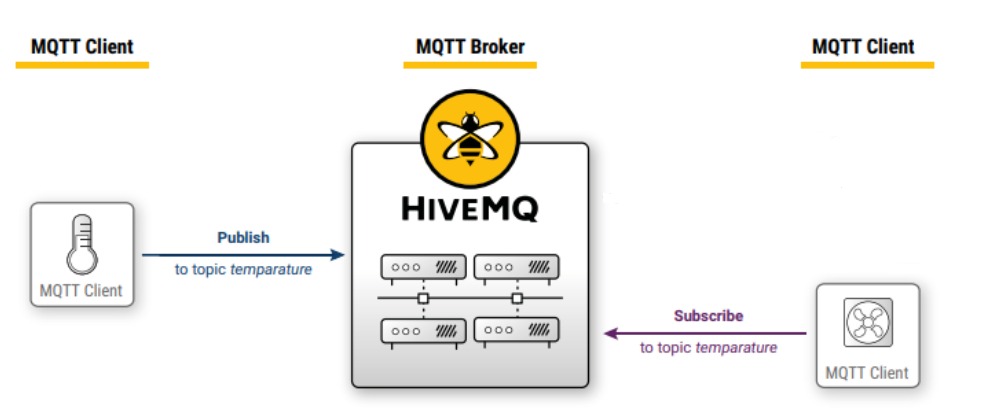

For our project, clients which send messages across the system could be the Beam Loss Monitors (BLMs), sending signals about the beam loss. 
Receiving clients could be our computers, which need to receive the live signals about beam loss. 

#### Setting up MQTT

Now that we understand how MQTT works, let's see how to set it up and use it for our projects. As mentioned before, we want to use MQTT to receive live signals about the beam loss of the synchrotron.

#### Packages to install:
Highlight uncomment (press ctrl + /) the packages that you don't have installed. Run the cell to install these packages onto your machine.

In [1]:
# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install paho-mqtt

#### Structure of MQTT Client Class

In python, we use classes as a blueprint to create objects with certain properties and methods. An object that we might need in our code is an *MQTT client*. We can do this with the help of a package that we've installed above: `paho.mqtt.client`.
This package gives us all of the basic blueprints to create a client which can recieve messages from a broker. 

To learn more about classes, [click here](https://www.w3schools.com/python/python_classes.asp)

The MQTT Client class always includes 4 key functions:  
  
```json
    def on_connect(self, client, userdata, flags, rc):
        print('Connected to ' + str(mqtt_topic))
        self.subscribe(mqtt_topic)
```  
This tells the client which topic to subscribe to - e.g: `temperature` in the example above.  
Subscribing to a topic in the on_connect() function means that if we lose the connection and reconnect then subscriptions will be renewed.  
  
  
    
```json
    def on_disconnect(self, client, userdata, rc):
        print('Disconnected from ' + str(mqtt_topic))
```       
We might not need our client to be connected to the broker forever - we will need a way to disconnect.  
The on_disconnect() function disconnects the client from the broker cleanly. This doesn't wait for all queued message to be sent, so you may risk missing out on some messages. 
```json
    def on_publish(self, client, userdata, mid):
        pass
```

on_publish() is called when a message that was to be sent has completed transmission to the broker. We won't need to send any messages to the broker, our client will only be receiving messages, so nothing will happen when this function is called. 
```json
    def on_message(self, client, userdata, message):
        msg_byte = message.payload
        msg_decode = np.frombuffer(msg_byte, dtype=float, count=-1, offset=0)
        msg_array = np.reshape(msg_decode, (40, 2200))
        print(msg_array)
```        
on_message() is called when a message has been received from a topic that the client subscribes to. This is the function which we will be using the most. In the previous example, this function would be called every time the central broker receives a new temperature from the thermometer.  

The messages sent over MQTT are sent as bytes, so we receive a string of bytes which need to be decoded.
The function above saves the encoded message in the variable `message_byte` and then decodes the message in the line below and saves the decoded message as `message_dict`.
The function then prints the message topic, followed by the decoded message.

#### Example: MQTT receiving client
The cell below contains all of the necessary code for a basic client which subscribes to our work experience topic and prints the messages received.  
Run the cell to see what messages are being sent.

In [5]:
# at the start of our program, we'll need to import all of the libraries that we are using. 
# python libraries contain pre-written functions that we can use in our programs

import paho.mqtt.client as mqtt
import numpy as np
import string
import json
import random
import time

# we don't need to pay much attention to the "generate_shortuuid" function, 
# it creates a unique user id for any client connected to our broker so that we
# can track how many people are subscribed to a channel, we can leave it alone.

def generate_shortuuid() -> str:
    """Public function for generating short UUID messages"""
    alphabet = string.ascii_lowercase + string.ascii_uppercase + string.digits
    shortuiid = "".join(random.choices(alphabet, k=12))
    return shortuiid

class MQTTClient(mqtt.Client):
    """
    A basic Client that connects to the broker. It logs connections
    and allows subscribing and receiving.

    You can modify the behaviour by changing the on_message, on_connect 
    etc. functions. For now, we just print the message whenever it comes through.
    """

    def __init__(self, topic_name, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.topic_name = topic_name

    def on_connect(self, client, userdata, flags, rc):
        print('Connected to: ' + str(self.topic_name))
        # we connect and subscribe to the topic in the connection so that
        # if the connection is broken it will always resubscribe
        self.subscribe(self.topic_name)

    def on_disconnect(self, client, userdata, rc):
        print('Disconnected from: ' + str(self.topic_name))
        
    # on_message is a function which is run every time we receive a message
    # from our specified topic from the broker.
    
    def on_message(self, client, userdata, message):
        msg_byte = message.payload
        """
        NOTE the message payload comes through as bytes so if you want 
        to do any manipulation of the data, we will need to decode and 
        reshape the data into a form that we can use.
        I'd recommend leaving the two lines below untouched,
        np.frombuffer decodes the message and n.reshape reshapes the 
        message into a form that is easier to manipulate.
        """
        msg_decode = np.frombuffer(msg_byte, dtype=float, count=-1, offset=0)
        msg_array = np.reshape(msg_decode, (40, 2200))
        print(msg_array)

# this is the function that we actually run - it takes in two arguments: 
# the topic name to connect to and the time period, the length of 
# time to leave the connection open for.
def get_live_data(topic_name, time_period):
    client = MQTTClient(topic_name)
    client.connect("130.246.57.45", 8883, 60)
    client.loop_start()
    time.sleep(time_period)
    client.disconnect()
    client.loop_stop()
        
get_live_data("ac_phys/workxp/live_signals", 5)

Connected to: acc_phys_workxp_data
Disconnected from: acc_phys_workxp_data


### Plotting our data
The messages being sent on this topic are stored Beam Loss Monitor and Intensity Monitor data.
We now know how to use MQTT to get live data - now we need to know how to plot it.  

First, we need to understand the format that our data come in as. Our data comes in as a 2D numpy array, which means that it comes in as a list of many lists. 
Each live message is a list: `message = [BLM0, BLM1, BLM2, BLM3, BLM4, ..., etc]` and BLM0 will be a list of datapoints between -0.5 ms and 10.5 ms: `BLM0 = [0.1, 0.023, 1.23, 1.67, ..., etc]`


We can use a python library called `matplotlib` to help us create visualisations of our data. 



In [ ]:
import paho.mqtt.client as mqtt
import numpy as np
import string
import json
import random
import time

def generate_shortuuid() -> str:
    """Public function for generating short UUID messages"""
    alphabet = string.ascii_lowercase + string.ascii_uppercase + string.digits
    shortuiid = "".join(random.choices(alphabet, k=12))
    return shortuiid

class MQTTClient(mqtt.Client):
    def __init__(self, topic_name, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.topic_name = topic_name

    def on_connect(self, client, userdata, flags, rc):
        print('Connected to: ' + str(self.topic_name))
        self.subscribe(self.topic_name)

    def on_disconnect(self, client, userdata, rc):
        print('Disconnected from: ' + str(self.topic_name))
        
    def on_message(self, client, userdata, message):
        msg_byte = message.payload
        msg_decode = np.frombuffer(msg_byte, dtype=float, count=-1, offset=0)
        msg_array = np.reshape(msg_decode, (40, 2200))
        print(msg_array)

# this is the function that we actually run - it takes in two arguments: 
# the topic name to connect to and the time period, the length of 
# time to leave the connection open for.
def get_live_data(topic_name, time_period):
    client = MQTTClient(topic_name)
    client.connect("130.246.57.45", 8883, 60)
    client.loop_start()
    time.sleep(time_period)
    client.disconnect()
    client.loop_stop()
        
get_live_data("ac_phys/workxp/live_signals", 5)